In [ ]:
! pip install fasttext-langdetect==1.0.5 stanza==1.7.0 minet==1.5.1 tqdm==4.64.1 matplotlib==3.6.2

# Download image data

Download all images in a folder called `insta_images`. The name of the image file associated to the url of each post is stored in a file called:

`tussenkunstenquarantaine_and_gettymuseumchallenge_insta_posts_fetch_report.csv`

In [ ]:
! minet fetch display_url -i 'tussenkunstenquarantaine_and_gettymuseumchallenge_insta_posts.csv' --folder-strategy 'prefix-2' -O 'insta_images'> tussenkunstenquarantaine_and_gettymuseumchallenge_insta_posts_fetch_report.csv

# Download text data

Warning: this script is **extremely** long (1 post/minute).
It downloads metadata about the instagram posts, and store it in a file called: 

`tussenkunstenquarantaine_and_gettymuseumchallenge_insta_posts_rich.csv`

In [ ]:
! minet insta post-infos url -i 'tussenkunstenquarantaine_and_gettymuseumchallenge_insta_posts.csv' > 'tussenkunstenquarantaine_and_gettymuseumchallenge_insta_posts_rich.csv'

In [19]:
TEXT_DATA = 'tussenkunstenquarantaine_and_gettymuseumchallenge_insta_posts_rich.csv'

# Language detection

## Use FastText

In [13]:
from ftlangdetect import detect
import casanova
from tqdm import tqdm
import re

Predict language from `caption` column. If confidence score < 0.7, language is marked as `uncertain`. Result is stored in a file called:

`tussenkunstenquarantaine_and_gettymuseumchallenge_insta_posts_rich_with_lang.csv`

In [15]:
with open(TEXT_DATA) as input_file, \
     open(TEXT_DATA.replace(".csv", "_with_lang.csv"), 'w') as output_file:

    enricher = casanova.enricher(input_file, output_file, add=['lang', 'lang_score'])
    caption_pos = enricher.headers.caption

    for row in tqdm(enricher):
        text_preprocessed = re.sub(r'[#@&][\S]+', '', row[caption_pos]).replace("\n", " ")
        result = detect(text=text_preprocessed, low_memory=False)
        if result["score"] > 0.7:
            enricher.writerow(row, [result["lang"], result["score"]])
        else:
            enricher.writerow(row, ["uncertain", result["score"]])

10it [00:00, 3646.27it/s]


## Visualize results

In [20]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from datetime import datetime, timedelta

In [22]:
counter_all = Counter()
counter_weeks_pretty = defaultdict(Counter)
counter_weeks_sorted = defaultdict(Counter)

with casanova.reader(TEXT_DATA.replace(".csv", "_with_lang.csv")) as reader:
    lang_pos = reader.headers.lang
    date_pos = reader.headers.utc_time
    
    for row in reader:
        date = datetime.fromisoformat(row[date_pos])
        week_day = date.weekday()
        last_monday = date - timedelta(days=week_day)
        
        counter_weeks_pretty[last_monday.strftime("%d/%m/%Y")][row[lang_pos]] += 1
        if date.year == 2020 and 2 < date.month < 5 :
            counter_weeks_sorted[last_monday.strftime("%Y-%m-%d")][row[lang_pos]] += 1
        
        
        counter_all[row[lang_pos]] += 1

In [25]:
enum = 0
print("rank", " | ", "lang", " | ", "count")
for lang, lang_count in counter_all.most_common():
    if lang != "uncertain":
        enum += 1
        print(str(enum).ljust(len("rank")), 
                              " | ", 
                              lang.ljust(len("lang")), 
                              " | ", 
                              lang_count)

rank  |  lang  |  count
1     |  en    |  27448
2     |  ru    |  8115
3     |  fr    |  5981
4     |  es    |  3324
5     |  nl    |  2434
6     |  it    |  2033
7     |  de    |  1476
8     |  pt    |  1202
9     |  ja    |  597
10    |  fi    |  538
11    |  tr    |  351
12    |  pl    |  315
13    |  ca    |  223
14    |  fa    |  212
15    |  hu    |  201
16    |  uk    |  191
17    |  zh    |  65
18    |  sv    |  59
19    |  ko    |  41
20    |  gl    |  39
21    |  no    |  37
22    |  ar    |  30
23    |  bg    |  25
24    |  el    |  19
25    |  ro    |  18
26    |  he    |  16
27    |  be    |  15
28    |  cs    |  8
29    |  da    |  8
30    |  th    |  7
31    |  hy    |  7
32    |  eo    |  7
33    |  id    |  7
34    |  ka    |  6
35    |  lv    |  6
36    |  ta    |  6
37    |  sq    |  5
38    |  la    |  4
39    |  sr    |  4
40    |  bn    |  3
41    |  lt    |  3
42    |  az    |  2
43    |  ceb   |  2
44    |  af    |  2
45    |  sh    |  2
46    |  vi    |  2
47  

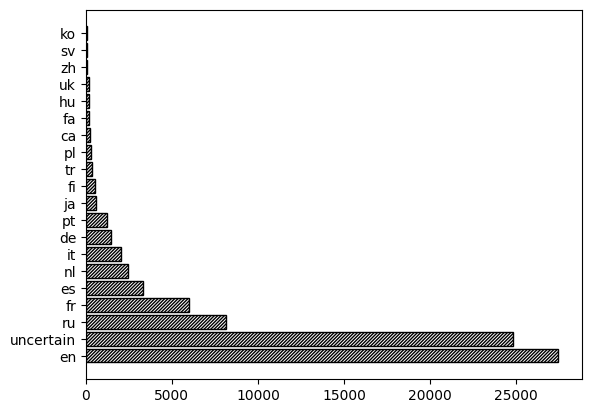

In [29]:
plt.barh(
    [m[0] for m in most_common], 
    [m[1] for m in most_common], 
    fill=False,
    hatch='/'*10
)
plt.savefig("most_common_20_languages.png")

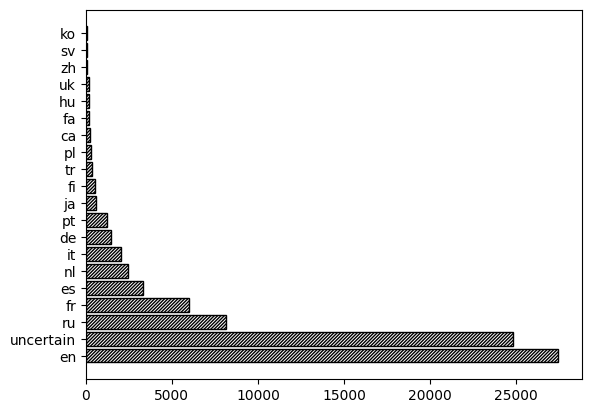

In [26]:
most_common = counter_all.most_common(20)
plt.barh(
    [m[0] for m in most_common], 
    [m[1] for m in most_common], 
    fill=False,
    hatch='/'*10
)
plt.savefig("most_common_20_languages.png")

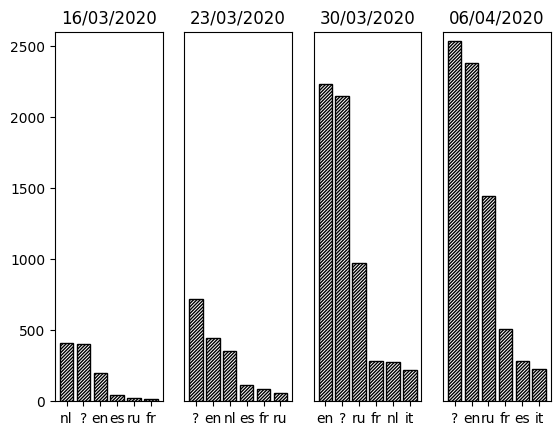

In [27]:
fig = plt.figure()
for enum, week in enumerate(["16/03/2020", "23/03/2020", "30/03/2020", "06/04/2020"]):
    ax = fig.add_subplot(140 + enum + 1)
    ax.set_ylim([0, 2600])
    ax.title.set_text(week)
    if enum != 0:
        ax.axes.get_yaxis().set_visible(False)
    most_common_languages = counter_weeks_pretty[week].most_common(6)
    ax.bar(
        [m[0].replace("uncertain", "?") for m in most_common_languages], 
        [m[1] for m in most_common_languages],
        fill=False,
        hatch='/'*10
    )
plt.savefig("most_common_6_languages_first_weeks.png")
    

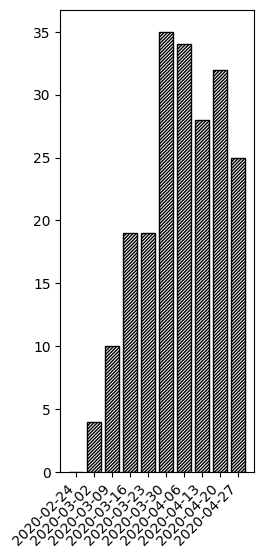

In [28]:
sorted(counter_weeks_sorted)
plt.figure(figsize=(2.5, 6))
fig = plt.bar(
    sorted(counter_weeks_sorted), 
    [len(counter_weeks_sorted[c]) - 1 for c in sorted(counter_weeks_sorted)], 
    color="black",
    fill=False,
    hatch='/'*10

)
plt.xticks(rotation=45, ha='right')
plt.savefig("number_of_languages_first_weeks.png", bbox_inches="tight")

# Named Entity recognition
Detect named entities for posts where the language was detected. Store the result in a file called 
`tussenkunstenquarantaine_and_gettymuseumchallenge_insta_posts_rich_with_ner.csv`

In [ ]:
import stanza

nlp_dict = {}
for l in ["en", "ru", "fr", "es", "nl", "it", "de", "ja"]:
    nlp_dict[l] = stanza.Pipeline(l, processors='tokenize,ner')

In [ ]:
with open(TEXT_DATA.replace(".csv", "_with_lang.csv")) as input_file, \
     open(TEXT_DATA.replace(".csv", "_with_ner.csv"), 'w') as output_file:
    selected_categories = ['PER', 'LOC', 'ORG', 'WORK_OF_ART', 'FAC', 'MISC']
    
    enricher = casanova.enricher(input_file, output_file, add=selected_categories)

    # You can iterate over its rows
    caption_pos = enricher.headers.caption
    lang_pos = enricher.headers.lang
        
    for row in tqdm(enricher):
        text_preprocessed = re.sub(r'[#@&][\S]+', '', row[caption_pos])
        lang = row[lang_pos]
        add = {key: [] for key in selected_categories}
        if lang != "uncertain" and lang in nlp_dict:
            doc = nlp_dict[lang](text_preprocessed)
            
            for ent in doc.ents:
                if ent.type == "PERSON":
                    add["PER"].append(ent.text)
                elif ent.type in add:
                    add[ent.type].append(ent.text)
        enricher.writerow(row, ["|".join(value) for value in add.values()])

Import file containing the names of the painters in different languages

In [48]:
import csv
with open('painters.csv', 'r') as f:
    reader = csv.DictReader(f)
    painters = next(reader)
painters = {k: v.split(", ") for k, v in painters.items()}
painters

{'picasso': ['picasso', 'pablo picasso', 'пабло пикассо', 'пикассо'],
 'van gogh': ['van gogh', 'vincent van gogh', 'vincent', 'ван гога'],
 'kahlo': ['frida', 'frida kahlo', 'фрида кало'],
 'vermeer': ['johannes vermeer',
  'vermeer',
  'ян вермеер',
  'jan vermeer',
  'яна вермеера'],
 'magritte': ['rené magritte', 'magritte', 'rene magritte', 'рене магритт'],
 'klimt': ['gustav klimt', 'klimt', 'густав климт'],
 'da vinci': ['leonardo da vinci', 'леонардо да винчи', 'mona lisa'],
 'caravaggio': ['caravaggio'],
 'schiele': ['egon schiele', 'schiele']}

In [43]:
painters_count = Counter()

In [53]:
with open(TEXT_DATA.replace(".csv", "_with_ner.csv")) as input_file:
    reader = csv.DictReader(input_file)
    for row in reader:
        persons = row["PER"].lower().split("|")
        for painter, names in painters.items():
            for person in persons:
                if person in names:
                    painters_count[painter] += 1

In [59]:
painters_count.most_common()

[('picasso', 949),
 ('van gogh', 887),
 ('kahlo', 816),
 ('vermeer', 749),
 ('magritte', 697),
 ('klimt', 460),
 ('da vinci', 390),
 ('caravaggio', 275),
 ('schiele', 247)]

## Visualize results

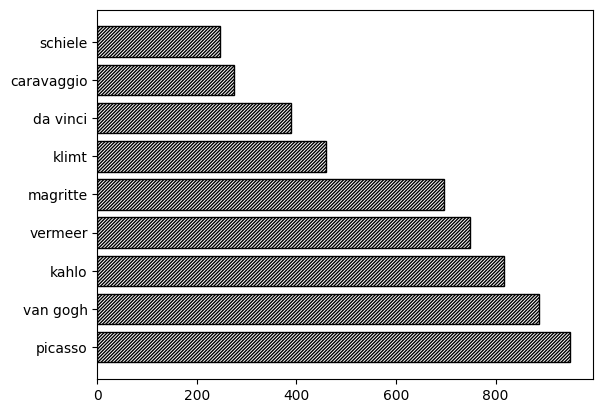

In [60]:
plt.barh(
    [m[0] for m in painters_count.most_common()], 
    [m[1] for m in painters_count.most_common()], 
    fill=False,
    hatch='/'*10
)
plt.savefig("most_common_painters.png", bbox_inches="tight")